In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset2.zip','r')

zip_ref.extractall()
zip_ref.close()

In [5]:
import os
import shutil
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


In [6]:
# Constants
IMAGE_SIZE = 224  # ViT requires fixed input size
PATCH_SIZE = 16   # ViT patch size (16×16 patches)

In [7]:
# Verify Images Function
def verify_images(directory):
    broken_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception as e:
                print(f" Corrupted image: {file_path} | Error: {e}")
                broken_images.append(file_path)
    return broken_images

In [8]:
import os
print(os.listdir("/content/large dataset"))
dataset=("/content/large dataset")

['train', 'test']


In [9]:
 #Train/Val Split
def split_dataset(base_dir, val_ratio=0.15):
    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        # Only include image files
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) == 0:
            print(f"⚠ No images found in {cls_path}")
            continue

        # Split
        train_imgs, val_imgs = train_test_split(images, test_size=val_ratio, random_state=42)

        # Create validation folder manually
        val_dir = os.path.join(base_dir.replace('Training', 'Validation'), cls)
        os.makedirs(val_dir, exist_ok=True)

        # Move validation images
        for img in val_imgs:
            src = os.path.join(cls_path, img)
            dst = os.path.join(val_dir, img)
            shutil.move(src, dst)

        print(f"✅ Moved {len(val_imgs)} images to {val_dir}")

In [10]:
# Transformations
import torch
from torchvision import transforms

# Define image size and normalization values for Swin Transformer / ImageNet
image_size = 224
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

# Define training transformations (with augmentations)
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),            # Resize to 224x224
    transforms.RandomHorizontalFlip(),                      # Randomly flip image
    transforms.RandomRotation(15),                          # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Random brightness/contrast
    transforms.ToTensor(),                                  # Convert PIL to Tensor
    transforms.Normalize(mean=mean_vals, std=std_vals)      # Normalize
])

# Define validation transformations (only resizing and normalization)
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

In [11]:
# Load Dataset
def load_datasets(train_path, val_path):
    train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
    return train_loader, val_loader, train_dataset.classes




In [12]:
# STEP 7: Display Sample Images
def imshow_batch(loader, classes):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    def unnormalize(img):
        img = img * torch.tensor(std_vals).view(3,1,1) + torch.tensor(mean_vals).view(3,1,1)
        return img

    fig, axes = plt.subplots(1, 8, figsize=(20, 3))
    for i in range(8):
        img = unnormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

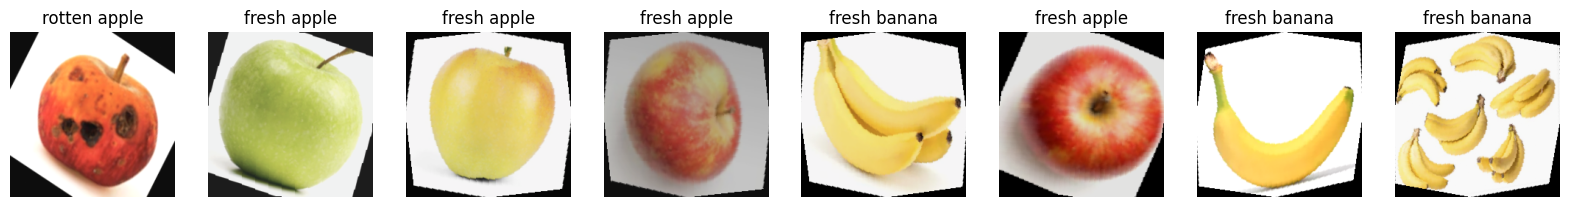

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

train_path = '/content/large dataset/train'
val_path = '/content/large dataset/test'

# Call load_datasets and assign the output to train_loader, val_loader and class_names
train_loader, val_loader, class_names = load_datasets(train_path, val_path)

# Now you can call imshow_batch:
imshow_batch(train_loader, class_names)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm

In [15]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ViT preprocessing parameters
image_size = 224  # ViT expects 224x224 images
mean_vals = [0.5, 0.5, 0.5]
std_vals = [0.5, 0.5, 0.5]


# Define data transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

In [16]:
# Load dataset
train_dir = "/content/large dataset/train"
test_dir = "/content/large dataset/test"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

print(train_dataset.class_to_idx)

# Check and adjust the number of classes in your model
num_classes = len(train_dataset.classes) # Get the actual number of classes
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
model.to(device)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

{'fresh apple': 0, 'fresh banana': 1, 'rotten apple': 2, 'rotten banana': 3}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [17]:
# Training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [19]:
# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Train and evaluate the model
train_model(model, train_loader, epochs=3)
evaluate_model(model, test_loader)

Epoch [1/3], Loss: 0.2943
Epoch [2/3], Loss: 0.0646
Epoch [3/3], Loss: 0.0117
Test Accuracy: 99.60%


In [20]:
def predict_fruit(image_path):
    try:
        # Load and preprocess the image
        img = Image.open(image_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Perform prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)

        # Get the prediction result
        return class_names[predicted.item()]

    except Exception as e:
        return f"Error processing the image: {e}"

# Main function for user input
def main():
    image_path = input("Enter the path to the fruit image: ")
    if not image_path:
        print(" Please provide a valid image path.")
        return

    prediction = predict_fruit(image_path)
    print(f"Prediction: The fruit is {prediction}.")

# This condition ensures the `main` function is called only when the script is executed directly, not imported.
if __name__ == "__main__": # Changed `_name_` to `__name__`
    main()

Enter the path to the fruit image: /content/FA.jpg
Prediction: The fruit is fresh apple.


Enter the paths to the fruit images, separated by commas: /content/FA.jpg,/content/FB.jpeg,/content/RA.jpeg,/content/RB.jpeg
Processing image 1: /content/FA.jpg
Prediction for image 1: The fruit is fresh apple.


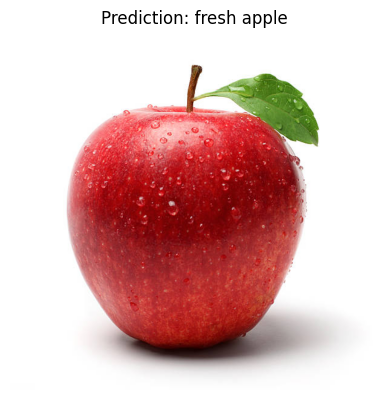

Processing image 2: /content/FB.jpeg
Prediction for image 2: The fruit is fresh banana.


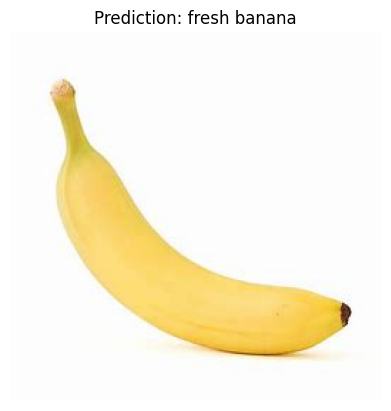

Processing image 3: /content/RA.jpeg
Prediction for image 3: The fruit is rotten apple.


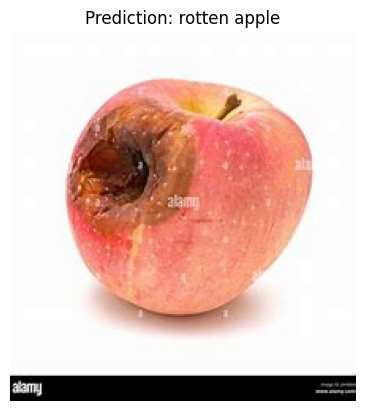

Processing image 4: /content/RB.jpeg
Prediction for image 4: The fruit is rotten banana.


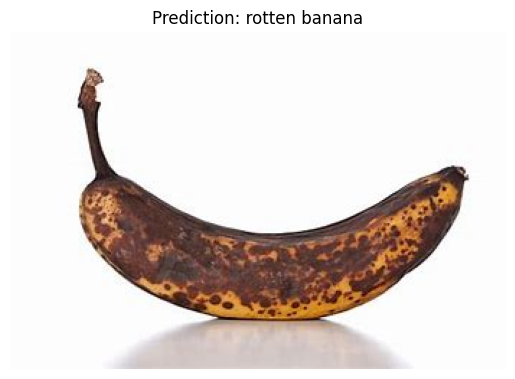

In [25]:
# Main function for user input
def main():
    image_paths = input("Enter the paths to the fruit images, separated by commas: ")
    if not image_paths:
        print("Please provide valid image paths.")
        return

    image_paths = [path.strip() for path in image_paths.split(",")]  # Split and clean paths

    for idx, image_path in enumerate(image_paths):
        print(f"Processing image {idx + 1}: {image_path}")
        prediction = predict_fruit(image_path)  # Get the prediction
        print(f"Prediction for image {idx + 1}: The fruit is {prediction}.")

        # Load the image for display (if prediction was successful)
        if not prediction.startswith("Error"):
            img = Image.open(image_path)
            plt.imshow(img)
            plt.title(f"Prediction: {prediction}")
            plt.axis('off')
            plt.show()

if __name__ == "__main__":
    main()